In [ ]:
from rHeston import *

In [ ]:
import torch
from roug_heston_rafactor import *
alpha = 0.3
params = (alpha, 0.13156, -0.5, 0.04, 0.1, 0.131)

# Use CPU by default for a light test
dev = torch.device("cuda")

t_vals, S_vals, V_vals = simulate_rough_vol_batch_torch(
    alpha=alpha,
    f=lambda V: f_heston_like_torch(V, kappa=0.1, theta=0.13156),
    g=lambda V: g_heston_like_torch(V, nu=0.131),
    V0=0.04,
    S0=100.0,
    r=0.0,
    rho=-0.5,
    T=0.2,
    N=50,
    N_exp=2,
    M=500,
    device=dev,
)
surface = compute_vol_surface(params, device=dev, show=False)

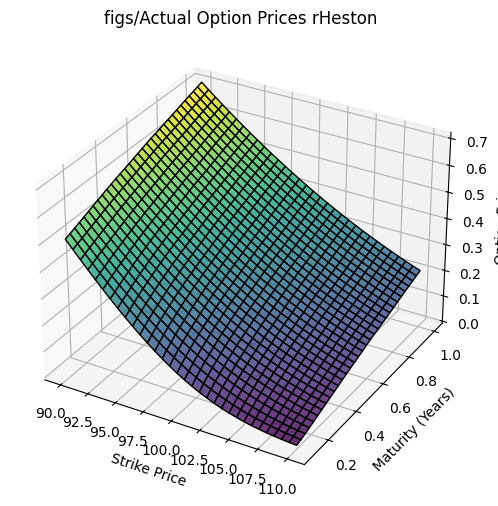

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
# Define a function to plot the implied volatility surface
def plot_iv_surface(strikes, maturities, surface, title="Implied Volatility Surface", z_axis = "Option Price"):
    strikes, maturities = np.meshgrid(strikes, maturities)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(strikes, maturities, surface, cmap="viridis", edgecolor="k", alpha=0.8)

    # Labels and title
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Maturity (Years)")
    ax.set_zlabel(z_axis)
    ax.set_title(title)
    plt.savefig(title + '.png')
    plt.show()


# Example: Plot the first IV surface
T_range = np.linspace(0.1, 1.0, num=32)    # 32 maturities
K_range = np.linspace(90.0, 110.0, num=32)  # 32 strikes
surface_to_plot = surface # Select the first surface
plot_iv_surface(K_range, T_range, surface_to_plot/20, title="figs/Actual Option Prices rHeston")


In [ ]:
"""
edm_sampling.py

EDM sampler utilities (refactored) for inverse problems framed on a grid,
renamed from 'Darcy Flow' to 'Rough Heston' per request.

Functionality preserved from the original script.
"""

from __future__ import annotations

from typing import Optional, Tuple

import numpy as np
import torch
import tqdm
import scipy.io


__all__ = [
    "random_index",
    "get_rough_heston_loss",
    "edm_sampler",
]


def random_index(
    k: int,
    grid_size: int,
    seed: int = 0,
    device: torch.device = torch.device("cuda"),
) -> torch.Tensor:
    """
    Randomly select k indices from a [grid_size, grid_size] grid and
    return a mask tensor of shape (grid_size, grid_size) with 1s at
    the selected locations and 0s elsewhere.
    """
    np.random.seed(seed)
    indices = np.random.choice(grid_size**2, k, replace=False)
    indices_2d = np.unravel_index(indices, (grid_size, grid_size))
    indices_list = list(zip(indices_2d[0], indices_2d[1]))

    mask = torch.zeros((grid_size, grid_size), dtype=torch.float32, device=device)
    for i in indices_list:
        mask[i] = 1.0
    return mask


def get_rough_heston_loss(
    u: torch.Tensor,
    u_gt: torch.Tensor,
    u_mask: torch.Tensor,
    device: torch.device = torch.device("cuda"),
) -> torch.Tensor:
    """
    Return the observation loss (masked residual) for the 'Rough Heston' grid.
    Mirrors original behavior: returns the masked residual (not a scalar).
    """
    # (u - u_gt) then apply mask; squeeze as in the original code path.
    observation_loss_u = (u - u_gt).squeeze()
    observation_loss_u = observation_loss_u * u_mask
    return observation_loss_u


def edm_sampler(
    net,
    u_GT,
    class_labels: Optional[torch.Tensor] = None,
    randn_like=torch.randn_like,
    num_steps: int = 2000,
    sigma_min: float = 0.002,
    sigma_max: float = 80.0,
    rho: float = 7.0,
    seed: int = 32,
    device: torch.device = torch.device("cuda"),
    zeta_obs_u: float = 1000,  # kept for API parity; unused in original
) -> Tuple[np.ndarray, torch.Tensor]:
    """
    EDM sampling loop adapted to the 'Rough Heston' naming.
    Behavior (updates, norms, scalings) matches the original code.

    Returns:
        u_final: np.ndarray with the final sampled field (shape preserved)
        masked_gt: torch.Tensor = u_GT.squeeze() * known_index_u (as in original)
    """
    # ----------------------- Load data & seed ---------------------------------
    u_GT = torch.tensor(u_GT, dtype=torch.float64, device=device)
    torch.manual_seed(seed)

    # ----------------------- Set up EDM latent --------------------------------
    print(f"Generating {1} samples for Rough Heston...")
    latents = torch.randn(
        [1, net.img_channels, net.img_resolution, net.img_resolution],
        device=device,
    )

    if getattr(net, "label_dim", 0):
        class_labels = torch.eye(net.label_dim, device=device)[
            torch.randint(net.label_dim, size=[1], device=device)
        ]
    else:
        class_labels = None

    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
    sigma_t_steps = (
        sigma_max ** (1.0 / rho)
        + step_indices / (num_steps - 1) * (sigma_min ** (1.0 / rho) - sigma_max ** (1.0 / rho))
    ) ** rho
    sigma_t_steps = torch.cat([net.round_sigma(sigma_t_steps), torch.zeros_like(sigma_t_steps[:1])])  # t_N = 0

    x_next = latents.to(torch.float64) * sigma_t_steps[0]

    # Note: pass device through to keep tensors on the same device.
    known_index_u = random_index(100, 32, seed=0, device=device)

    # ----------------------- Sampling loop ------------------------------------
    for i, (sigma_t_cur, sigma_t_next) in tqdm.tqdm(
        list(enumerate(zip(sigma_t_steps[:-1], sigma_t_steps[1:]))),
        unit="step",
    ):
        x_cur = x_next.detach().clone()
        x_cur.requires_grad = True
        sigma_t = net.round_sigma(sigma_t_cur)

        # Euler step
        x_N = net(x_cur, sigma_t, class_labels=class_labels).to(torch.float64)
        d_cur = (x_cur - x_N) / sigma_t
        x_next = x_cur + (sigma_t_next - sigma_t) * d_cur

        # 2nd-order correction
        if i < num_steps - 1:
            x_N = net(x_next, sigma_t_next, class_labels=class_labels).to(torch.float64)
            d_prime = (x_next - x_N) / sigma_t_next
            x_next = x_cur + (sigma_t_next - sigma_t) * (0.5 * d_cur + 0.5 * d_prime)

        # Scale back & extract first channel
        u_N = x_N[:, 0, :, :].unsqueeze(0)

        # Masked observation loss (same as original)
        observation_loss_u = get_rough_heston_loss(u_N, u_GT, known_index_u, device=device)
        L_obs_u = torch.norm(observation_loss_u, p=2) / 100.0

        grad_x_cur_obs_u = torch.autograd.grad(outputs=L_obs_u, inputs=x_cur, retain_graph=True)[0]

        # Gradient guidance step sizes preserved
        if i <= 0.8 * num_steps:
            x_next = x_next - grad_x_cur_obs_u * 4.0
        else:
            x_next = x_next - grad_x_cur_obs_u * 4.0

    # ----------------------- Post-process & save ------------------------------
    x_final = x_next
    u_final = x_final[:, 0, :, :].unsqueeze(0)

    relative_error_u = torch.norm(u_final - u_GT, 2) / torch.norm(u_GT, 2)
    print(f"Relative error of Rough Heston u: {relative_error_u}")

    u_final_np = u_final.detach().cpu().numpy()
    scipy.io.savemat("rough_heston_results.mat", {"u": u_final_np})
    print("Done.")

    return u_final_np, u_GT.squeeze() * known_index_u


In [ ]:
import pickle

device = torch.device('cuda')
f = open("/content/drive/MyDrive/github/roughheston/rough_heston/pretrained/network-snapshot-000302.pkl", 'rb')
net = pickle.load(f)['ema'].to(device)

In [ ]:
u_final  ,partial = edm_sampler(net ,  surface /20)

Generating 1 samples for Rough Heston...


100%|██████████| 2000/2000 [03:19<00:00, 10.01step/s]

Relative error of Rough Heston u: 0.005636970298495305
Done.


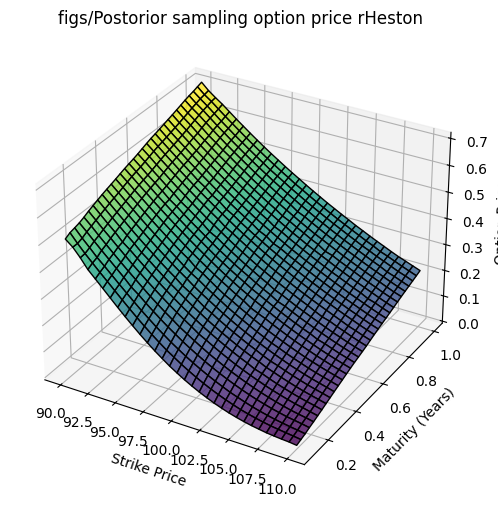

In [ ]:
plot_iv_surface(K_range, T_range, u_final.squeeze(), title="figs/Postorior sampling option price rHeston")


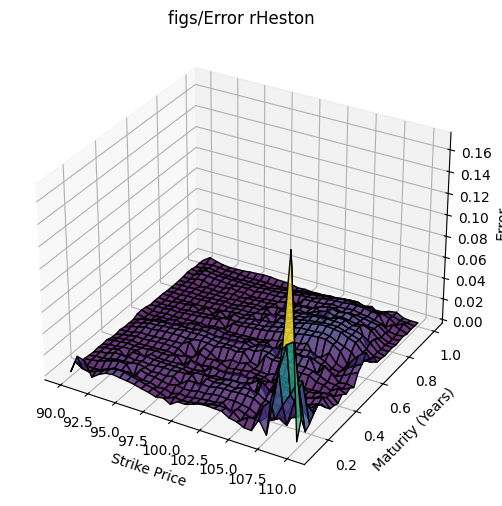

In [ ]:
result = np.abs( (u_final.squeeze() - surface/20)/(surface/20))
plot_iv_surface(K_range, T_range, result, title="figs/Error rHeston" , z_axis="Error")


In [ ]:
def plot_iv_scatter(strikes, maturities, surface, title="Implied Volatility Surface"):
    # Create a meshgrid for strikes and maturities
    strikes, maturities = np.meshgrid(strikes, maturities)

    # Flatten arrays for filtering
    strikes = strikes.flatten()
    maturities = maturities.flatten()
    surface = surface.flatten()

    # Filter out points where the surface value is zero
    mask = surface != 0
    strikes = strikes[mask]
    maturities = maturities[mask]
    surface = surface[mask]

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    scatter = ax.scatter(
        strikes, maturities, surface, c=surface,  alpha=0.8
    )

    # Labels and title
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Maturity (Years)")
    ax.set_zlabel("Option Price")
    ax.set_title(title)

    # Add color bar

    plt.savefig(title + '.png')
    plt.show()

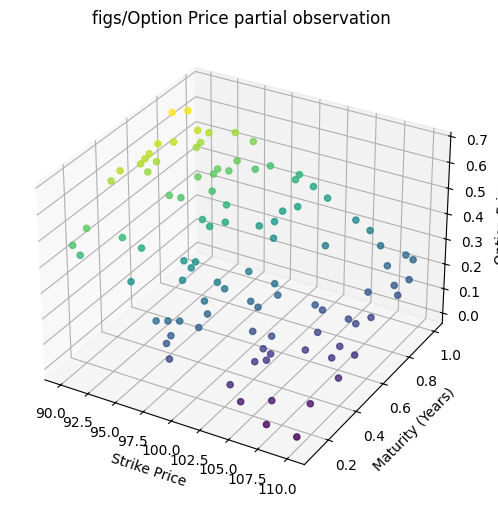

In [ ]:
plot_iv_scatter(K_range, T_range,partial.detach().cpu().numpy()  , title="figs/Option Price partial observation")
